# Demo RNA usando Auto-Keras para identificar clases

Fuente:https://autokeras.com/

0) Preparar el ambiente

In [ ]:
#@title Instalar Auto-Keras 
#!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install keras-tuner --upgrade
!pip install autokeras


     |████████████████████████████████| 98 kB 2.6 MB/s 
     |████████████████████████████████| 166 kB 5.4 MB/s 
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 454.4 MB 23 kB/s 
     |████████████████████████████████| 4.0 MB 45.2 MB/s 
     |████████████████████████████████| 1.2 MB 42.7 MB/s 
     |████████████████████████████████| 462 kB 50.9 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68712 sha256=854dd4171dc8fd7726d3a8735ef346205df8c79c67453a3066ccc872f04b02b1
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.43.0
    Uninstalling grpcio-

1) Cargar librerías:

In [ ]:
#@title Librerías a usar
import autokeras as ak

from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import os
import csv

print("Librerías cargadas")

Librerías cargadas


2) Cargar los datos:

In [ ]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
## selección de los parámetros 

def cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return atributo_clase, nombre_clases

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'ANIMALES.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo clase / objetivo:
atributo_clase = '-' #@param {type:"string"}
#@markdown ### Descripción de los valores del atributo clase / objetivo:  (nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, agregar "na")
nombre_clases = '-' #@param {type:"string"}
#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   70#@param {type:"integer"}

## aplicación de los parámetros elegidos

if atributo_clase == '' or  atributo_clase == '-':
  # trata de obtener la configuración del archivo asociado
  atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases)


# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_clase

# define valores de clases para ejemplo IRIS
CLASES = [ ]
for val in nombre_clases.split(','):
  CLASES.append( val )

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

print("Configuración definida de ", archivo_datos)
print("Atributo clase: ", ClassAttributeName, ": ", CLASES)


> Definición de los valores discretos para la clase cargada de ANIMALES_nombreClases.txt.

Configuración definida de  ANIMALES.csv
Atributo clase:  TIPO :  ['na', 'MAMIFERO', 'AVE', 'REPTIL', 'PEZ', 'ANFIBIO', 'INSECTO', 'INVERTEBRADO']


In [ ]:
#@title Cargar datos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())

# genera los datos solo con la clase para entrenar y probar
Y = df.pop(ClassAttributeName)
X = df

# convierte a numpy para tener compatibilidad con AutoKeras
X = X.to_numpy()
Y = Y.to_numpy()

#X = X.astype(np.unicode)
#Y = Y.astype(np.unicode)



> Cabecera: 
   TIENE_PELO  TIENE_PLUMAS  PONE_HUEVOS  DA_LECHE  ES_AEREO  ES_ACUATICO  \
0           1             0            0         1         0            0   
1           1             0            0         1         0            0   
2           0             0            1         0         0            1   
3           1             0            0         1         0            0   
4           1             0            0         1         0            0   

   ES_PREDADOR  TIENE_DIENTES  TIENE_COLUMNA  RESPIRA  ES_VENENOSO  \
0            1              1              1        1            0   
1            0              1              1        1            0   
2            1              1              1        0            0   
3            1              1              1        1            0   
4            0              1              1        1            0   

   TIENE_ALETAS  CANT_PATAS  TIENE_COLA  ES_DOMESTICO  TIPO  
0             0           4           0 

In [ ]:
#@title Preparar datos

# separa al azar usando muestreo estratificado con proporción indicada
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)

# genera salida codificada para softMax
y_trainEnc =  to_categorical(y_train)
y_testEnc =  to_categorical(y_test)

# muestra resultados
print("> Para Ambos: ")
print(" - dictMapeo: ", CLASES)

print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
for i in range(len(CLASES)):
  cant = 0
  for y in y_train:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
for i in range(len(CLASES)):
  cant = 0
  for y in y_test:
    if i == y: cant = cant + 1
  print("    ", CLASES[i], "[", i, "]:", cant)


> Para Ambos: 
 - dictMapeo:  ['na', 'MAMIFERO', 'AVE', 'REPTIL', 'PEZ', 'ANFIBIO', 'INSECTO', 'INVERTEBRADO']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (34, 15)
 - y_train (cant):  34
     na [ 0 ]: 0
     MAMIFERO [ 1 ]: 10
     AVE [ 2 ]: 5
     REPTIL [ 3 ]: 3
     PEZ [ 4 ]: 3
     ANFIBIO [ 5 ]: 3
     INSECTO [ 6 ]: 4
     INVERTEBRADO [ 7 ]: 6

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (16, 15)
 - y_test (cant):  16
     na [ 0 ]: 0
     MAMIFERO [ 1 ]: 5
     AVE [ 2 ]: 3
     REPTIL [ 3 ]: 2
     PEZ [ 4 ]: 1
     ANFIBIO [ 5 ]: 1
     INSECTO [ 6 ]: 2
     INVERTEBRADO [ 7 ]: 2


3) Establecer el modelo para la RNA

In [ ]:
#@title Establecer modelo base para AutoKeras

cantidad_intentos_encontrar_modelo = 5 #@param {type:"integer"}
if cantidad_intentos_encontrar_modelo < 1:
  cantidad_intentos_encontrar_modelo = 1

max_epocas_entrenamiento =  300#@param {type:"integer"}
if max_epocas_entrenamiento <= 0:
  max_epocas_entrenamiento = None

# AutoKeras siempre se usa salida softmax 
# (se puede usar salida lineal pero lo aplica el pipeline,
#  no el modelo que se exporta)
tipo_output_softMax = True

AKmodel = ak.StructuredDataClassifier(num_classes=len(CLASES), 
                                      overwrite=True, 
                                      seed=1,
                                      max_trials=cantidad_intentos_encontrar_modelo)

print("Modelo preparado")

Modelo preparado


4) Entrenar el modelo de la RNA:

In [ ]:
#@title Entrenar con AutoKeras

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       (y_trainEnc if tipo_output_softMax else y_train), 
                                       test_size=0.1)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

# el history sólo devuelve el del último trial
#history = 
AKmodel.fit(x_t, y_t,
                      validation_data=(x_v, y_v,),
                      epochs=max_epocas_entrenamiento
                      )

print("\n>Entrenamiento Finalizado.")


Trial 5 Complete [00h 00m 39s]
val_accuracy: 0.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 03m 19s
INFO:tensorflow:Oracle triggered exit
Epoch 1/300
1/1 [==============================] - 1s 937ms/step - loss: 2.2608 - accuracy: 0.1333 - val_loss: 2.2455 - val_accuracy: 0.2500
Epoch 2/300
1/1 [==============================] - 0s 37ms/step - loss: 2.2260 - accuracy: 0.2000 - val_loss: 2.2192 - val_accuracy: 0.2500
Epoch 3/300
1/1 [==============================] - 0s 37ms/step - loss: 2.1918 - accuracy: 0.2000 - val_loss: 2.1930 - val_accuracy: 0.2500
Epoch 4/300
1/1 [==============================] - 0s 37ms/step - loss: 2.1579 - accuracy: 0.2000 - val_loss: 2.1681 - val_accuracy: 0.2500
Epoch 5/300
1/1 [==============================] - 0s 37ms/step - loss: 2.1247 - accuracy: 0.2000 - val_loss: 2.1437 - val_accuracy: 0.5000
Epoch 6/300
1/1 [==============================] - 0s 39ms/step - loss: 2.0923 - accuracy: 0.2000 - val_loss: 2.1197 - val_accuracy: 0.5000
Epoch 7/3

In [ ]:
 #@title Mostrar Resumen de las Pruebas realizadas por AutoKeras
 print(AKmodel.tuner.results_summary())

resEval = AKmodel.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Mejor Modelo con datos de Prueba: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

Results summary
Results in ./structured_data_classifier
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
structured_data_block_1/normalize: True
structured_data_block_1/dense_block_1/use_batchnorm: False
structured_data_block_1/dense_block_1/num_layers: 2
structured_data_block_1/dense_block_1/units_0: 32
structured_data_block_1/dense_block_1/dropout: 0
structured_data_block_1/dense_block_1/units_1: 32
classification_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.001
Score: 1.0
Trial summary
Hyperparameters:
structured_data_block_1/normalize: True
structured_data_block_1/dense_block_1/num_layers: 2
structured_data_block_1/dense_block_1/use_batchnorm: False
structured_data_block_1/dense_block_1/dropout: 0
structured_data_block_1/dense_block_1/units_0: 32
structured_data_block_1/dense_block_1/units_1: 32
classification_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.001
Score: 0.75
Trial summary
Hyperparameters:
structured_da

In [ ]:
#@title Exportar Modelo y Re-Entrenar (opcional)

reentrenar_modelo = False #@param {type:"boolean"}

cant_epocas_reentrenamiento =  500#@param {type:"integer"}
if cant_epocas_reentrenamiento <= 0:
  cant_epocas_reentrenamiento = None


# exporta el modelo y lo muestra
print("\n>> Mejor modelo generado: ")
model = AKmodel.export_model()
model.summary()
print("")

if reentrenar_modelo: 
  # realiza el re-entrenamiento del modelo
  print("\n\n>Comienza el Re-Entrenamiento:")
  history = model.fit(x_t, y_t,
                        validation_data=(x_v, y_v,),
                        epochs=cant_epocas_reentrenamiento
                        )
  print("\n>Re-Entrenamiento Finalizado.")


>> Mejor modelo generado: 
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 15)                0         
_________________________________________________________________
normalization (Normalization (None, 15)                31        
_________________________________________________________________
dense (Dense)                (None, 32)                512       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (Non

*** Resultados con datos de Entrenamiento: 
Real: ANFIBIO / RNA: ANFIBIO (5): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: AVE / RNA: AVE (2): ok
Real: AVE / RNA: AVE (2): ok
Real: AVE / RNA: AVE (2): ok
Real: REPTIL / RNA: REPTIL (3): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: PEZ / RNA: PEZ (4): ok
Real: INVERTEBRADO / RNA: INVERTEBRADO (7): ok
Real: PEZ / RNA: PEZ (4): ok
Real: AVE / RNA: AVE (2): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: INVERTEBRADO / RNA: INVERTEBRADO (7): ok
Real: INSECTO / RNA: INSECTO (6): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: INSECTO / RNA: INSECTO (6): ok
Real: INSECTO / RNA: INSECTO (6): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: INSECTO / RNA: INSECTO (6): ok
Real: REPTIL / RNA: REPTIL (3): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: INVERTEBRADO / RNA: INVERTEBRADO (7): ok
Real: INVERTEBRADO / RNA: INVERTEBR

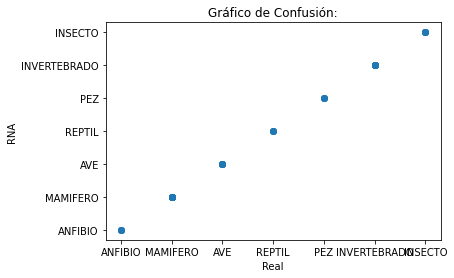

In [ ]:
#@title Probar red entrenada con datos de entrenamiento
# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, clases_map):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ] 

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = int(predClass[i][0])       
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:      
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + clReal + ' / RNA: ' 
        strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'   
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    print(cmtx)
    print("\n")

    # gráfico de comparación
    plt.title('Gráfico de Confusión:')
    plt.xlabel('Real')
    plt.ylabel('RNA')
    plt.scatter(classReal, classPreds)

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, CLASES)


6) Evaluar el modelo de la RNA entrenado con los datos de prueba:

1/1 [==============================] - 0s 232ms/step - loss: 0.3307 - accuracy: 0.9375

>Evaluación del Modelo: 
    - Error:  0.3306977152824402
    - Exactitud:  93.75




*** Resultados con datos de Prueba: 
Real: INVERTEBRADO / RNA: INVERTEBRADO (7): ok
Real: INSECTO / RNA: INSECTO (6): ok
Real: AVE / RNA: AVE (2): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: REPTIL / RNA: REPTIL (3): ok
Real: INSECTO / RNA: INSECTO (6): ok
Real: REPTIL / RNA: INVERTEBRADO (7): error!
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: MAMIFERO / RNA: MAMIFERO (1): ok
Real: PEZ / RNA: PEZ (4): ok
Real: AVE / RNA: AVE (2): ok
Real: ANFIBIO / RNA: ANFIBIO (5): ok
Real: AVE / RNA: AVE (2): ok
Real: INVERTEBRADO / RNA: INVERTEBRADO (7): ok

 Reporte de Clasificación: 
              precision    recall  f1-score   support

     ANFIBIO       1.00      1.00      1.00         1
         AVE       1.00      1.00      1.00         3
 

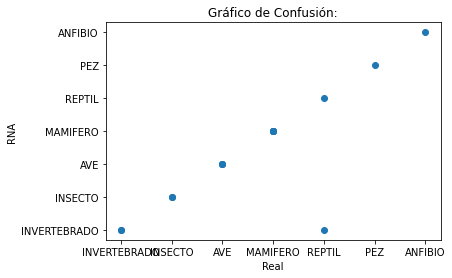

In [ ]:
 #@title Probar red entrenada con datos de prueba
 # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test),)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, CLASES)